# WHO COVID-19 Global Data — Data Cleaning Pipeline
**Project:** Early Warning System for Pandemic Risk Using WHO Surveillance Data  
**Team:** Jayesh Sawarkar (POC), Roshni More, Insha Maniyar  
**Data Source:** [WHO COVID-19 Dashboard](https://data.who.int/dashboards/covid19/data)  
**Granularity:** Country × Week (already weekly in source)  
**Time Span:** Jan 2020 – Jan 2026  
**Countries:** ~240 countries/territories

---
## Step 0 — Imports & Configuration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ---------- CONFIG ----------
RAW_FILE = '/workspaces/group-project-inferra/Data/WHO-COVID-19-global-data_uncleaned.csv'
CLEAN_FILE = '/workspaces/group-project-inferra/Data/WHO_COVID19_cleaned.csv'           # output
print('Setup complete ✅')

Setup complete ✅
/workspaces/group-project-inferra/Data/WHO-COVID-19-global-data_uncleaned.csv


---
## Step 1 — Load Raw Data & Initial Inspection

In [5]:
df_raw = pd.read_csv(RAW_FILE)
print(f'Shape: {df_raw.shape}')
df_raw.head(10)

Shape: (75840, 8)


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-05,AF,Afghanistan,EMRO,NaN,0,NaN,0
1,2020-01-12,AF,Afghanistan,EMRO,NaN,0,NaN,0
2,2020-01-19,AF,Afghanistan,EMRO,NaN,0,NaN,0
3,2020-01-26,AF,Afghanistan,EMRO,NaN,0,NaN,0
4,2020-02-02,AF,Afghanistan,EMRO,NaN,0,NaN,0
5,2020-02-09,AF,Afghanistan,EMRO,NaN,0,NaN,0
6,2020-02-16,AF,Afghanistan,EMRO,NaN,0,NaN,0
7,2020-02-23,AF,Afghanistan,EMRO,NaN,0,NaN,0
8,2020-03-01,AF,Afghanistan,EMRO,1.0,1,NaN,0
9,2020-03-08,AF,Afghanistan,EMRO,NaN,1,NaN,0


In [6]:
# Data types and basic info
df_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 75840 entries, 0 to 75839
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      75840 non-null  str    
 1   Country_code       75524 non-null  str    
 2   Country            75840 non-null  str    
 3   WHO_region         70152 non-null  str    
 4   New_cases          50309 non-null  float64
 5   Cumulative_cases   75840 non-null  int64  
 6   New_deaths         36341 non-null  float64
 7   Cumulative_deaths  75840 non-null  int64  
dtypes: float64(2), int64(2), str(4)
memory usage: 4.6 MB


In [7]:
# Summary statistics for numeric columns
df_raw.describe()

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,5.030900e+04,7.584000e+04,36341.000000,7.584000e+04
mean,1.548607e+04,2.136421e+06,195.637627,2.227410e+04
std,2.386410e+05,8.771151e+06,1015.832840,8.858398e+04
min,-6.507900e+04,0.000000e+00,-3432.000000,0.000000e+00
25%,9.000000e+00,7.375000e+03,0.000000,4.400000e+01
50%,1.590000e+02,6.387950e+04,5.000000,7.430000e+02
75%,2.098000e+03,6.728120e+05,50.000000,8.515500e+03
max,4.047548e+07,1.034368e+08,47687.000000,1.233841e+06


---
## Step 2 — Missing Value Analysis

In [8]:
# 2a. Count & percentage of missing values per column
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
missing_summary = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_summary)
print(f'\nTotal rows: {len(df_raw)}')

                   Missing Count  Missing %
Date_reported                  0       0.00
Country_code                 316       0.42
Country                        0       0.00
WHO_region                  5688       7.50
New_cases                  25531      33.66
Cumulative_cases               0       0.00
New_deaths                 39499      52.08
Cumulative_deaths              0       0.00

Total rows: 75840


In [9]:
# 2b. Which countries have missing WHO_region?
missing_region = df_raw[df_raw['WHO_region'].isna()]['Country'].unique()
print(f'Countries with missing WHO_region ({len(missing_region)}):')
for c in sorted(missing_region):
    print(f'  • {c}')

Countries with missing WHO_region (18):
  • Falkland Islands (Malvinas)
  • Faroe Islands
  • French Guiana
  • Gibraltar
  • Guadeloupe
  • Guernsey
  • Holy See
  • Isle of Man
  • Jersey
  • Liechtenstein
  • Martinique
  • Mayotte
  • Pitcairn
  • R�union
  • Saint Barth�lemy
  • Saint Helena
  • Saint Martin (French part)
  • Saint Pierre and Miquelon


In [10]:
# 2c. Which countries have missing Country_code?
missing_code = df_raw[df_raw['Country_code'].isna()]['Country'].unique()
print(f'Countries with missing Country_code ({len(missing_code)}):')
for c in sorted(missing_code):
    print(f'  • {c}')

Countries with missing Country_code (1):
  • Namibia


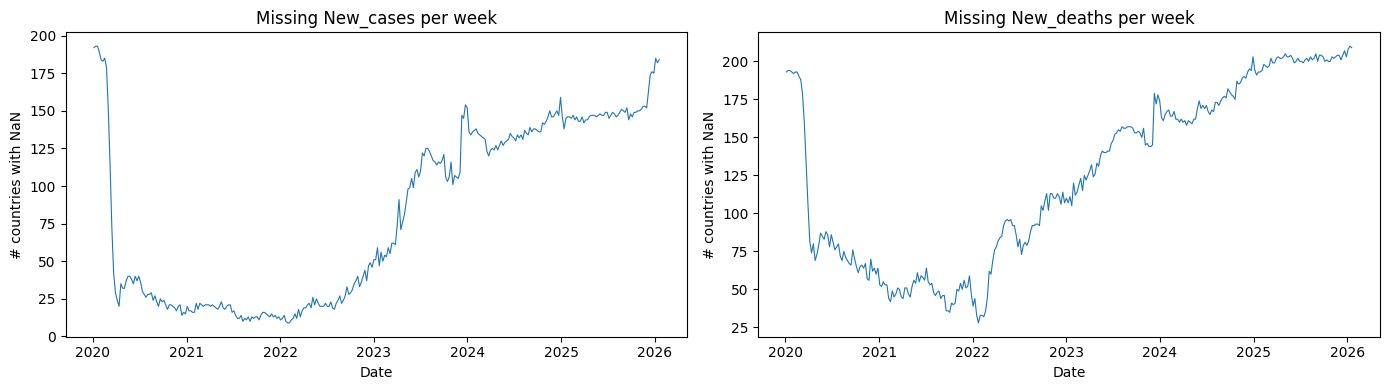

Observation: Missing values increase in later weeks as countries stopped reporting.


In [11]:
# 2d. Visualize missingness pattern for New_cases and New_deaths over time
df_temp = df_raw.copy()
df_temp['Date_reported'] = pd.to_datetime(df_temp['Date_reported'])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, col in zip(axes, ['New_cases', 'New_deaths']):
    missing_by_week = df_temp.groupby('Date_reported')[col].apply(lambda x: x.isna().sum())
    ax.plot(missing_by_week.index, missing_by_week.values, linewidth=0.8)
    ax.set_title(f'Missing {col} per week')
    ax.set_xlabel('Date')
    ax.set_ylabel('# countries with NaN')

plt.tight_layout()
plt.show()
print('Observation: Missing values increase in later weeks as countries stopped reporting.')

---
## Step 3 — Data Type Corrections

In [12]:
df = df_raw.copy()

# 3a. Convert Date_reported to datetime
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

# 3b. Extract useful time features (will help in later EDA/modeling)
df['Year'] = df['Date_reported'].dt.year
df['Week_num'] = df['Date_reported'].dt.isocalendar().week.astype(int)

print('Date range:', df['Date_reported'].min().date(), 'to', df['Date_reported'].max().date())
print('dtypes after conversion:')
print(df.dtypes)

Date range: 2020-01-05 to 2026-01-18
dtypes after conversion:
Date_reported        datetime64[us]
Country_code                    str
Country                         str
WHO_region                      str
New_cases                   float64
Cumulative_cases              int64
New_deaths                  float64
Cumulative_deaths             int64
Year                          int32
Week_num                      int64
dtype: object


---
## Step 4 — Handle Missing `WHO_region` and `Country_code`

In [13]:
# 4a. Fill missing WHO_region using a manual mapping
#     (These are typically small territories or special entries)

# First check what the known region is for these countries (if any row has it)
for country in df[df['WHO_region'].isna()]['Country'].unique():
    known = df.loc[(df['Country'] == country) & df['WHO_region'].notna(), 'WHO_region'].unique()
    if len(known) > 0:
        print(f'{country}: found known region → {known[0]}')
    else:
        print(f'{country}: NO known region in data')

Saint Barth�lemy: NO known region in data
French Guiana: NO known region in data
Guernsey: NO known region in data
Falkland Islands (Malvinas): NO known region in data
Gibraltar: NO known region in data
Guadeloupe: NO known region in data
Jersey: NO known region in data
Isle of Man: NO known region in data
Liechtenstein: NO known region in data
Martinique: NO known region in data
Faroe Islands: NO known region in data
Saint Martin (French part): NO known region in data
R�union: NO known region in data
Pitcairn: NO known region in data
Holy See: NO known region in data
Saint Pierre and Miquelon: NO known region in data
Mayotte: NO known region in data
Saint Helena: NO known region in data


In [14]:
# 4b. For countries that NEVER have a region, assign 'OTHER' 
#     (or you can manually map them if you know the correct WHO region)

# Forward-fill within each country first (handles cases where region exists in some rows)
df['WHO_region'] = df.groupby('Country')['WHO_region'].transform(
    lambda x: x.ffill().bfill()
)

# Any remaining NaN → assign 'OTHER'
df['WHO_region'] = df['WHO_region'].fillna('OTHER')

print(f"Missing WHO_region after fix: {df['WHO_region'].isna().sum()}")
print(f"Countries tagged OTHER: {df[df['WHO_region']=='OTHER']['Country'].unique()}")

Missing WHO_region after fix: 0
Countries tagged OTHER: <StringArray>
[                           'Saint Barth�lemy',
                               'French Guiana',
                                    'Guernsey',
                 'Falkland Islands (Malvinas)',
                                   'Gibraltar',
                                  'Guadeloupe',
                                      'Jersey',
                                 'Isle of Man',
                               'Liechtenstein',
                                  'Martinique',
                               'Faroe Islands',
                  'Saint Martin (French part)',
                                     'R�union',
                                    'Pitcairn',
                                    'Holy See',
                   'Saint Pierre and Miquelon',
         'International conveyance (Kiribati)',
             'International commercial vessel',
                                     'Mayotte',
                  

In [15]:
# 4c. Fill missing Country_code — forward/backward fill within country
df['Country_code'] = df.groupby('Country')['Country_code'].transform(
    lambda x: x.ffill().bfill()
)
# Remaining NaN → 'UNK'
df['Country_code'] = df['Country_code'].fillna('UNK')

print(f"Missing Country_code after fix: {df['Country_code'].isna().sum()}")

Missing Country_code after fix: 0


---
## Step 5 — Handle Missing `New_cases` and `New_deaths`

In [16]:
# 5a. Understand the pattern:
#   - NaN in New_cases/New_deaths often means "no report that week" (not zero)
#   - However if Cumulative stays flat → the country truly had 0 new cases/deaths
#   - Strategy: fill NaN with 0 where Cumulative values didn't change,
#     otherwise keep NaN for transparency (we'll flag these rows)

print('Before filling:')
print(f"  New_cases NaN:  {df['New_cases'].isna().sum()}")
print(f"  New_deaths NaN: {df['New_deaths'].isna().sum()}")

Before filling:
  New_cases NaN:  25531
  New_deaths NaN: 39499


In [17]:
# 5b. Compute week-over-week change in cumulative columns per country
df = df.sort_values(['Country', 'Date_reported']).reset_index(drop=True)

df['Cumulative_cases_prev'] = df.groupby('Country')['Cumulative_cases'].shift(1)
df['Cumulative_deaths_prev'] = df.groupby('Country')['Cumulative_deaths'].shift(1)

# If cumulative didn't change → safe to fill NaN with 0
cases_flat = (df['Cumulative_cases'] == df['Cumulative_cases_prev'])
deaths_flat = (df['Cumulative_deaths'] == df['Cumulative_deaths_prev'])

# Fill NaN New_cases with 0 where cumulative is flat
df.loc[df['New_cases'].isna() & cases_flat, 'New_cases'] = 0
# Fill NaN New_deaths with 0 where cumulative is flat
df.loc[df['New_deaths'].isna() & deaths_flat, 'New_deaths'] = 0

# For remaining NaN: derive from cumulative difference
still_missing_cases = df['New_cases'].isna() & df['Cumulative_cases_prev'].notna()
df.loc[still_missing_cases, 'New_cases'] = (
    df.loc[still_missing_cases, 'Cumulative_cases'] - df.loc[still_missing_cases, 'Cumulative_cases_prev']
)

still_missing_deaths = df['New_deaths'].isna() & df['Cumulative_deaths_prev'].notna()
df.loc[still_missing_deaths, 'New_deaths'] = (
    df.loc[still_missing_deaths, 'Cumulative_deaths'] - df.loc[still_missing_deaths, 'Cumulative_deaths_prev']
)

# For the very first row of each country (no prev), fill remaining NaN with 0
df['New_cases'] = df['New_cases'].fillna(0)
df['New_deaths'] = df['New_deaths'].fillna(0)

# Drop helper columns
df.drop(columns=['Cumulative_cases_prev', 'Cumulative_deaths_prev'], inplace=True)

print('After filling:')
print(f"  New_cases NaN:  {df['New_cases'].isna().sum()}")
print(f"  New_deaths NaN: {df['New_deaths'].isna().sum()}")

After filling:
  New_cases NaN:  0
  New_deaths NaN: 0


---
## Step 6 — Handle Negative Values (Retrospective Corrections)

In [18]:
# 6a. Inspect negative values
neg_cases = df[df['New_cases'] < 0]
neg_deaths = df[df['New_deaths'] < 0]

print(f'Rows with negative New_cases:  {len(neg_cases)}')
print(f'Rows with negative New_deaths: {len(neg_deaths)}')
print()

if len(neg_cases) > 0:
    print('Negative New_cases examples:')
    display(neg_cases[['Date_reported','Country','New_cases','Cumulative_cases']].head(10))

if len(neg_deaths) > 0:
    print('\nNegative New_deaths examples:')
    display(neg_deaths[['Date_reported','Country','New_deaths','Cumulative_deaths']].head(10))

Rows with negative New_cases:  18
Rows with negative New_deaths: 13

Negative New_cases examples:


,Date_reported,Country,New_cases,Cumulative_cases
6438,2022-04-10,Belize,-2.0,57287
10612,2023-07-16,Burundi,-105.0,54216
14778,2024-08-25,Cook Islands,-1.0,7374
18996,2020-09-13,Ecuador,-1594.0,116451
20023,2022-03-20,Equatorial Guinea,-98.0,15800
22317,2023-10-15,Fiji,-7.0,69040
27189,2020-04-05,Guatemala,-27.0,50
39372,2023-08-13,Liberia,-160.0,7930
41228,2022-11-06,Malawi,-88.0,88009
43454,2023-02-12,Mauritania,-124.0,63438



Negative New_deaths examples:


,Date_reported,Country,New_deaths,Cumulative_deaths
3661,2023-07-23,Australia,-76.0,22694
7993,2021-10-17,"Bonaire, Saint Eustatius and Saba",-1.0,19
11820,2022-06-19,Canada,-331.0,41017
13125,2023-04-02,Chile,-3432.0,61050
13482,2024-01-14,China,-22.0,121916
26587,2020-11-01,Guadeloupe,-1.0,126
30866,2024-02-11,Indonesia,-4.0,162050
44791,2024-07-07,Micronesia (Federated States of),-3.0,62
52314,2023-05-07,Panama,-1.0,8620
52644,2023-08-13,Papua New Guinea,-30.0,640


In [19]:
# 6b. Strategy: Clip negatives to 0
#   Negative values are due to retrospective data corrections by countries.
#   For a forward-looking early warning system, we clip to 0 to avoid 
#   distorting growth rate calculations.
#   We also flag these rows for transparency.

df['flag_negative_correction'] = (
    (df['New_cases'] < 0) | (df['New_deaths'] < 0)
).astype(int)

df['New_cases'] = df['New_cases'].clip(lower=0)
df['New_deaths'] = df['New_deaths'].clip(lower=0)

print(f"Rows flagged as negative corrections: {df['flag_negative_correction'].sum()}")
print(f"Negative values remaining — New_cases: {(df['New_cases']<0).sum()}, New_deaths: {(df['New_deaths']<0).sum()}")

Rows flagged as negative corrections: 31
Negative values remaining — New_cases: 0, New_deaths: 0


---
## Step 7 — Duplicate Check

In [20]:
# 7a. Check for duplicate Country × Date combinations
dupes = df.duplicated(subset=['Country', 'Date_reported'], keep=False)
print(f'Duplicate Country × Date rows: {dupes.sum()}')

if dupes.sum() > 0:
    print('\nDuplicate examples:')
    display(df[dupes].sort_values(['Country','Date_reported']).head(10))
    
    # Drop duplicates — keep the last reported value
    df = df.drop_duplicates(subset=['Country', 'Date_reported'], keep='last')
    print(f'Shape after dedup: {df.shape}')
else:
    print('No duplicates found ✅')

Duplicate Country × Date rows: 0
No duplicates found ✅


---
## Step 8 — Verify Cumulative Consistency

In [21]:
# 8a. Check if Cumulative values are monotonically non-decreasing per country
df = df.sort_values(['Country', 'Date_reported']).reset_index(drop=True)

df['cum_cases_diff'] = df.groupby('Country')['Cumulative_cases'].diff()
df['cum_deaths_diff'] = df.groupby('Country')['Cumulative_deaths'].diff()

decreasing_cases = df[df['cum_cases_diff'] < 0]
decreasing_deaths = df[df['cum_deaths_diff'] < 0]

print(f'Rows where Cumulative_cases decreased: {len(decreasing_cases)}')
print(f'Rows where Cumulative_deaths decreased: {len(decreasing_deaths)}')

if len(decreasing_cases) > 0:
    print('\nCountries with decreasing cumulative cases:')
    print(decreasing_cases['Country'].unique())

# Drop helper columns
df.drop(columns=['cum_cases_diff', 'cum_deaths_diff'], inplace=True)

Rows where Cumulative_cases decreased: 18
Rows where Cumulative_deaths decreased: 13

Countries with decreasing cumulative cases:
<StringArray>
[                          'Belize',                          'Burundi',
                     'Cook Islands',                          'Ecuador',
                'Equatorial Guinea',                             'Fiji',
                        'Guatemala',                          'Liberia',
                           'Malawi',                       'Mauritania',
                          'Mayotte', 'Micronesia (Federated States of)',
                            'Palau',                      'Philippines',
                            'Samoa',        'Sint Maarten (Dutch part)',
     'United States Virgin Islands',                         'Zimbabwe']
Length: 18, dtype: str


---
## Step 9 — Weekly Completeness Check (Temporal Gaps)

In [22]:
# 9a. Check if each country has a complete weekly time series
country_stats = df.groupby('Country').agg(
    first_date=('Date_reported', 'min'),
    last_date=('Date_reported', 'max'),
    num_weeks=('Date_reported', 'count')
).reset_index()

# Expected weeks for each country (based on their own date range)
country_stats['expected_weeks'] = (
    (country_stats['last_date'] - country_stats['first_date']).dt.days // 7 + 1
)
country_stats['missing_weeks'] = country_stats['expected_weeks'] - country_stats['num_weeks']

gaps = country_stats[country_stats['missing_weeks'] > 0]
print(f'Countries with temporal gaps: {len(gaps)}')
if len(gaps) > 0:
    display(gaps.sort_values('missing_weeks', ascending=False).head(10))

Countries with temporal gaps: 0


In [ ]:
# 9b. (Optional) Fill temporal gaps with 0 new cases/deaths if needed
#      This ensures a complete time grid for time-series modeling.
#      Uncomment the block below if you want a fully rectangular panel.

# all_dates = pd.date_range(df['Date_reported'].min(), df['Date_reported'].max(), freq='7D')
# all_countries = df['Country'].unique()
# full_index = pd.MultiIndex.from_product([all_countries, all_dates], names=['Country','Date_reported'])
# df = df.set_index(['Country','Date_reported']).reindex(full_index).reset_index()
# ... then forward-fill metadata and fill NaN numeric with 0

print('Note: Temporal gap filling is optional — uncomment above if needed for modeling.')

---
## Step 10 — Outlier Detection (Extreme Spikes)

In [23]:
# 10a. Flag extreme spikes using country-level z-scores
#   A spike > 4 std from a country's mean is likely a data dump / correction

df['cases_zscore'] = df.groupby('Country')['New_cases'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

extreme_spikes = df[df['cases_zscore'].abs() > 4]
print(f'Rows with |z-score| > 4 for New_cases: {len(extreme_spikes)}')

if len(extreme_spikes) > 0:
    print('\nTop 10 extreme spikes:')
    display(
        extreme_spikes.nlargest(10, 'cases_zscore')[
            ['Date_reported', 'Country', 'New_cases', 'cases_zscore']
        ]
    )

# Flag but do NOT remove — these may be real surges
df['flag_extreme_spike'] = (df['cases_zscore'].abs() > 4).astype(int)
print(f"\nRows flagged as extreme spike: {df['flag_extreme_spike'].sum()}")

# Drop z-score helper (we'll recompute during feature engineering)
df.drop(columns=['cases_zscore'], inplace=True)

Rows with |z-score| > 4 for New_cases: 1056

Top 10 extreme spikes:


,Date_reported,Country,New_cases,cases_zscore
31988,2021-05-23,International conveyance (Kiribati),2.0,17.720134
53853,2022-07-24,Pitcairn,4.0,17.720134
32617,2021-05-02,International conveyance (Vanuatu),12.0,17.720134
30988,2020-05-24,International commercial vessel,29.0,17.720134
74405,2022-10-16,Wallis and Futuna,2654.0,17.534735
71815,2021-08-08,United Republic of Tanzania,20607.0,17.358884
32304,2021-05-23,International conveyance (Solomon Islands),4.0,17.190257
31333,2020-12-13,International conveyance (American Samoa),3.0,16.809023
29113,2020-10-18,Holy See,14.0,16.659024
57654,2022-09-25,Saint Helena,1298.0,16.608735



Rows flagged as extreme spike: 1056


---
## Step 11 — Convert to Integer Types

In [24]:
# New_cases and New_deaths should be integers after cleaning
df['New_cases'] = df['New_cases'].astype(int)
df['New_deaths'] = df['New_deaths'].astype(int)

print('Final dtypes:')
print(df.dtypes)

Final dtypes:
Date_reported               datetime64[us]
Country_code                           str
Country                                str
WHO_region                             str
New_cases                            int64
Cumulative_cases                     int64
New_deaths                           int64
Cumulative_deaths                    int64
Year                                 int32
Week_num                             int64
flag_negative_correction             int64
flag_extreme_spike                   int64
dtype: object


---
## Step 12 — Final Validation & Summary

In [25]:
# 12a. Final checks
print('=' * 60)
print('CLEANED DATA SUMMARY')
print('=' * 60)
print(f'Shape:               {df.shape}')
print(f'Date range:          {df["Date_reported"].min().date()} to {df["Date_reported"].max().date()}')
print(f'Unique countries:    {df["Country"].nunique()}')
print(f'Unique WHO regions:  {df["WHO_region"].nunique()} → {sorted(df["WHO_region"].unique())}')
print(f'Missing values:      {df.isnull().sum().sum()}')
print(f'Negative New_cases:  {(df["New_cases"] < 0).sum()}')
print(f'Negative New_deaths: {(df["New_deaths"] < 0).sum()}')
print(f'Duplicate rows:      {df.duplicated(subset=["Country","Date_reported"]).sum()}')
print(f'Flag columns:        flag_negative_correction, flag_extreme_spike')
print('=' * 60)

CLEANED DATA SUMMARY
Shape:               (75840, 12)
Date range:          2020-01-05 to 2026-01-18
Unique countries:    240
Unique WHO regions:  7 → ['AFRO', 'AMRO', 'EMRO', 'EURO', 'OTHER', 'SEARO', 'WPRO']
Missing values:      0
Negative New_cases:  0
Negative New_deaths: 0
Duplicate rows:      0
Flag columns:        flag_negative_correction, flag_extreme_spike


In [26]:
# 12b. Column overview
print('Final columns:')
for col in df.columns:
    print(f'  {col:30s}  {str(df[col].dtype):10s}  nulls={df[col].isna().sum()}')

Final columns:
  Date_reported                   datetime64[us]  nulls=0
  Country_code                    str         nulls=0
  Country                         str         nulls=0
  WHO_region                      str         nulls=0
  New_cases                       int64       nulls=0
  Cumulative_cases                int64       nulls=0
  New_deaths                      int64       nulls=0
  Cumulative_deaths               int64       nulls=0
  Year                            int32       nulls=0
  Week_num                        int64       nulls=0
  flag_negative_correction        int64       nulls=0
  flag_extreme_spike              int64       nulls=0


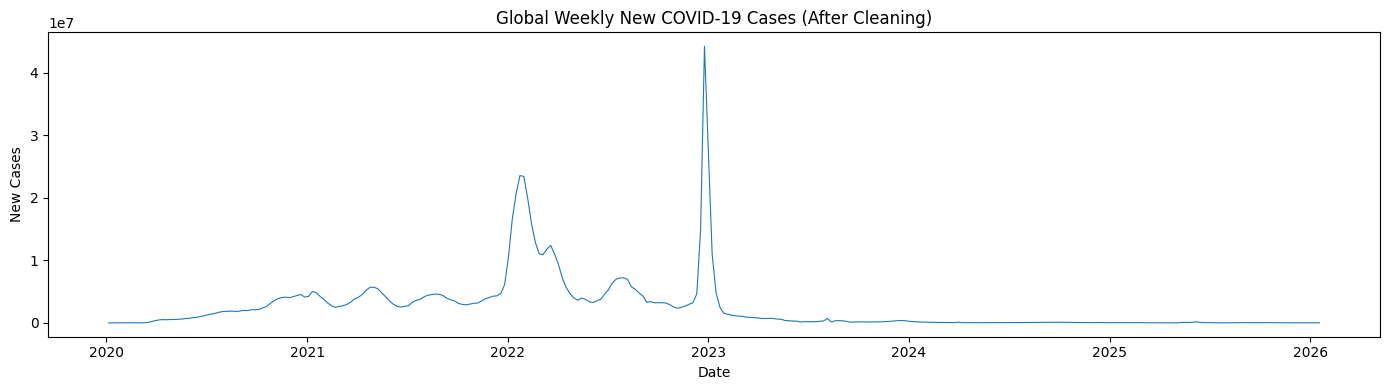

In [27]:
# 12c. Quick visual sanity check — global weekly cases
global_weekly = df.groupby('Date_reported')['New_cases'].sum()

plt.figure(figsize=(14, 4))
plt.plot(global_weekly.index, global_weekly.values, linewidth=0.8)
plt.title('Global Weekly New COVID-19 Cases (After Cleaning)')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.tight_layout()
plt.show()

In [28]:
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Year,Week_num,flag_negative_correction,flag_extreme_spike
0,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0,2020,1,0,0
1,2020-01-12,AF,Afghanistan,EMRO,0,0,0,0,2020,2,0,0
2,2020-01-19,AF,Afghanistan,EMRO,0,0,0,0,2020,3,0,0
3,2020-01-26,AF,Afghanistan,EMRO,0,0,0,0,2020,4,0,0
4,2020-02-02,AF,Afghanistan,EMRO,0,0,0,0,2020,5,0,0


---
## Step 13 — Export Cleaned Data

In [29]:
# Save the cleaned dataframe
df.to_csv(CLEAN_FILE, index=False)
print(f'Cleaned data saved to: {CLEAN_FILE}')
print(f'Shape: {df.shape}')

Cleaned data saved to: /workspaces/group-project-inferra/Data/WHO_COVID19_cleaned.csv
Shape: (75840, 12)
